In [1]:
# Imports

import numpy as np
import scipy
import skimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import napari

from seg_funcs import sort_xy, outline2map
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Import Data

In [2]:
# Import data and crop to channels and ROI

base_path = './data/'
image_path = 'control_example.tif'

data = skimage.io.imread(base_path + image_path)
data = np.moveaxis(data, [1], [0])

HT = data[0, :, 45:, 0:128]
CM = data[1, :, 45:, 0:128]

# Check image shape
HT.shape, CM.shape

((71, 211, 128), (71, 211, 128))

### Metadata

In [3]:
# Calculate average time per image
time_sample = (297.8334 - 105.4653)/69 # Done

# Calculate average pixel to pixel distance
pixel_size = .1
dist = (((pixel_size**2 + pixel_size**2)**.5) + pixel_size)/2

## Segmentation

In [4]:
# Segment cell membrane

mem_list = []

for image in HT:
    
    # Segment HT channel
    thresh = skimage.filters.threshold_otsu(image)
    image_bin = image > thresh
    
    # Clean up segmentation, fill holes, and erode to approriate size
    image_rem = skimage.morphology.remove_small_objects(image_bin, 100)
    image_fill = skimage.morphology.remove_small_holes(image_rem, 10000)
    image_ero = skimage.morphology.erosion(image_fill, skimage.morphology.disk(2))
    
    # Find outer bondaries of the cell and dilate to a 3 pixel width
    cell_out = skimage.segmentation.find_boundaries(image_ero, mode='inner', connectivity=2)
    cell_dil = skimage.morphology.dilation(cell_out, skimage.morphology.disk(1))
    mem_list.append(cell_dil)
    
mem_array = np.stack(mem_list)

In [5]:
# Check segmentation quality in Napari

viewer = napari.Viewer()
viewer.add_image(HT, blending='additive')
viewer.add_image(CM, blending='additive', contrast_limits=[0, np.max(CM)*.3])
viewer.add_image(mem_array, opacity=0.25, colormap='red', blending='additive')

<Image layer 'mem_array' at 0x7f770e5d2e60>

## Unraveling Cell Membrane

In [6]:
# Unravel mem_array and shift the center of the signal to center of the array

# Number of timepoints to fit over
tn = 60

# Generate unraveled array
cm_img, x_sor, y_sor = outline2map(mem_array[1:], CM[1:], n_images=tn, ang_shift=180)

/media/patrick/work_1/analysis/external_data/PI3K_CMDR_iFRAP/final/mem_flow/seg_funcs.py:24: RuntimeWarning: invalid value encountered in arccos
  angles_sorted = np.where((y_sorted-y0) > 0, np.arccos((x_sorted-x0)/r), 2*np.pi-np.arccos((x_sorted-x0)/r))


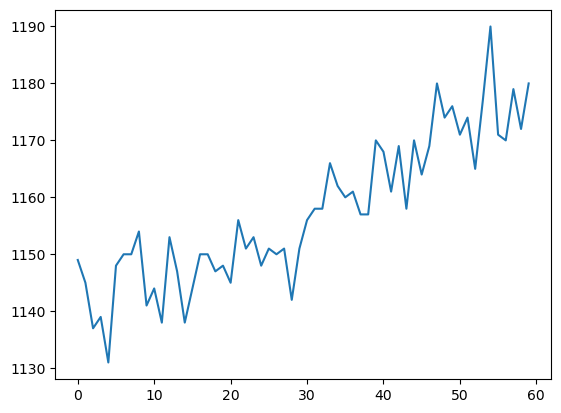

In [7]:
# Calculate the minimium cell edge length

edge_len = np.array([np.sum(array) for array in mem_array[1:tn+1]])
min_edge_len = int(np.min(edge_len))

plt.plot(edge_len)

In [8]:
# Trim unraveled membrane down to the shortest length

trimmed_list = []

for vals in cm_img:
    array = np.array(vals)
    n = len(array)//2
    trimmed = array[n-min_edge_len//2:n+min_edge_len//2]
    trimmed_list.append(trimmed)

trimmed_array = np.array(trimmed_list)

In [9]:
# Average every three pixels

mean_list = []

for v in trimmed_array:
    split_list = np.array_split(v, min_edge_len//3)
    mean_list.append([np.mean(k) for k in split_list])

trimmed_mean = np.stack(mean_list)

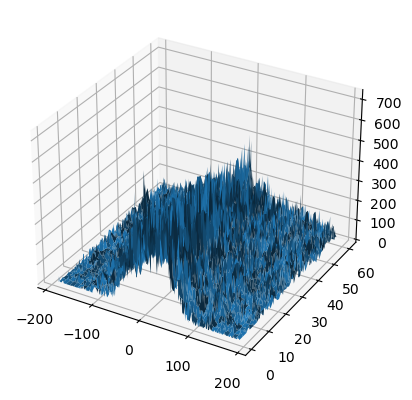

In [10]:
# Plot kymograph as surface, intensity values in space over time,
# and generate X and T values for fitting

nx, ny = trimmed_mean.shape[1], trimmed_mean.shape[0]
x = np.linspace(-nx//2, nx//2, nx)
y = range(1, ny+1)

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, T = np.meshgrid(x, y)
ha.plot_surface(X, T, trimmed_mean)

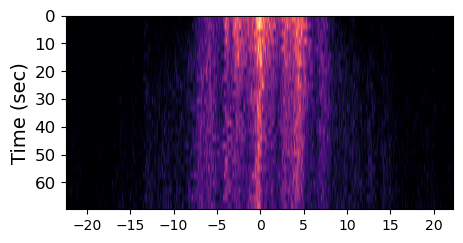

In [11]:
# Generate kymograph

x = X[0]*dist
x = x[3:-4]
y = np.arange(0,26)*time_sample

asp = ((np.abs(np.min(x))+np.max(x))/np.max(y))

p1, p2 = np.percentile(trimmed_array, (30, 99.95))
trim_re = skimage.exposure.rescale_intensity(trimmed_array, in_range=(p1, p2))

plt.figure(figsize=(5,5))
plt.imshow(trim_re[0:26], cmap='magma', extent=[np.min(x),np.max(x),np.max(y), 0], aspect=asp*.5)
plt.ylabel('Time (sec)', fontsize=14)
xticks = np.arange(np.round(np.min(x))+3, np.round(np.max(x)), 7)
yticks = np.arange(0, np.max(y), 10)
plt.yticks(yticks, fontsize=12);

## Fitting Normal Distributions

In [12]:
# Define Guassian for fitting each timepoint

def func(x, m, r0, c, off):
    terms = (m*np.exp(-((x-c)**2)/(2*r0**2))) + off
    return terms

In [13]:
# Fit each timepoint 

c_list = []
popt_list = []

for i in range(0,tn):    
    popt, pcov = curve_fit(func, X[i].flatten(), trimmed_mean[i].flatten())
    popt_list.append(popt)
    c_list.append(popt[2])
    
c_array = np.array(c_list)

# Replace c values with poor fits
c_array[c_array > 80] = np.nan

/home/patrick/miniconda3/envs/cv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


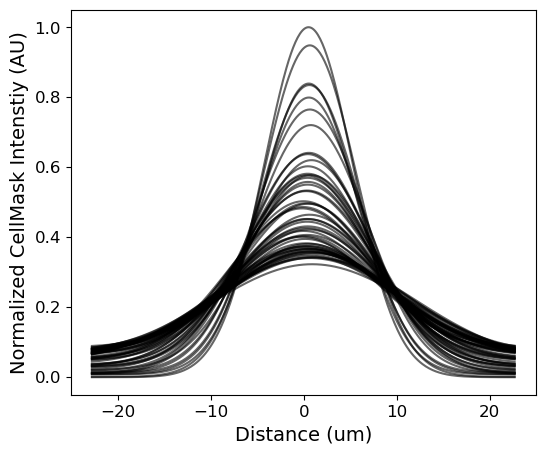

In [14]:
# Plot evolving normal distributions

plt.figure(figsize=(6,5))

y_norm_list = []

for i in range(0,tn):

    y = func(X[i].flatten(),
             popt_list[i][0], 
             popt_list[i][1], 
             popt_list[i][2], 
             popt_list[i][3])
    
    if i == 0:
        y_max = np.max(y)
    
    y_norm = y/y_max
    
    if np.isnan(c_array[i]) == True:
        pass
        
    else:
        plt.plot(X[0]*dist, 
                 y_norm, 
                 color='k',
                 alpha=.6)
        
        plt.xlabel('Distance (um)', fontsize=14)
        plt.ylabel('Normalized CellMask Intenstiy (AU)', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        y_norm_list.append(y_norm)

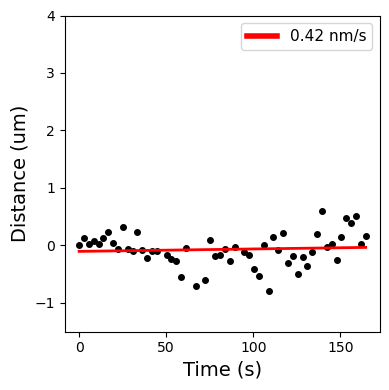

In [15]:
# Plot membrane flow

plt.figure(figsize=(4,4))

xt = np.arange(0,tn)*time_sample
yd = np.array(c_array[0:tn])*dist
yd = yd - yd[0]

mask = ~np.isnan(xt) & ~np.isnan(yd)
xt_m = xt[mask]
yd_m = yd[mask]

res = scipy.stats.linregress(xt_m, yd_m)
lab = "{} nm/s".format(np.round(res.slope*1000, 2))

plt.plot(xt_m, yd_m, marker='.', markersize=8, c='k', lw=0)
plt.plot(xt_m, 
         res.intercept + res.slope*xt_m, 
         'r', 
         label=lab,
         lw=2)
plt.ylim(-1.5,4)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Distance (um)', fontsize=14)
plt.tight_layout()

leg = plt.legend(fontsize=11)

for line in leg.get_lines():
    line.set_linewidth(4.0)

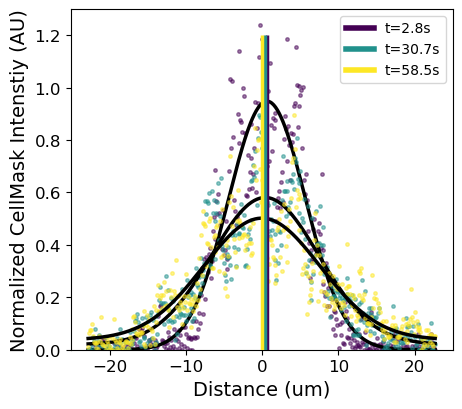

In [16]:
# Plot sample fits

vir = mpl.colormaps['viridis'].resampled(3)

plt.figure(figsize=(4.5*1.05,4*1.05))

n = 0
times = [1,11,21]

for i in times:
    
    y = func(X[i].flatten(),
             popt_list[i][0], 
             popt_list[i][1], 
             popt_list[i][2], 
             popt_list[i][3])
    
    if i == 0:
        y_max = np.max(y)
    
    y_norm = y/y_max
    
    plt.plot(X[0]*dist, 
             trimmed_mean[i]/y_max, 
             marker='.', 
             markersize=5,
             lw=0, 
             alpha=0.5,
             c=vir(n))
    
    plt.plot(X[0]*dist,
             y_norm,
             lw=2.5,
             c='k')
    
    plt.vlines(popt_list[i][2]*dist, 0, 1.2, lw=2.5, color=vir(n), zorder=100)
    
    plt.xlabel('Distance (um)', fontsize=14)
    plt.ylabel('Normalized CellMask Intenstiy (AU)', fontsize=14)
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
      
    n+=1

# Plot legend
custom_lines = [Line2D([0], [0], color=vir(0), lw=4),
                Line2D([0], [0], color=vir(1), lw=4),
                Line2D([0], [0], color=vir(2), lw=4)]

plt.ylim(0,1.3)

rt = time_sample*np.array(times)
t1 = 't={}s'.format(np.round(rt[0],1))
t2 = 't={}s'.format(np.round(rt[1],1))
t3 = 't={}s'.format(np.round(rt[2],1))

plt.legend(custom_lines, [t1 , t2, t3])